In [51]:
%load_ext autoreload
%autoreload 2
from agent_configs import make_agent
from training import run_training, train_reps, train_or_load_condition
from eval_funcs import avg_stats

def gauss(data, filters=[(0,100,1.0)]):
    from scipy.ndimage.filters import gaussian_filter1d
    for (st, en, sig) in filters:
        if(sig == 0): continue
        l = len(data) 
        en = max(en,l) if en != -1 else en
        if(l > st):
            data[st:en] = gaussian_filter1d(data[st:en],sigma=sig)
    return data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
agent = make_agent("mc", "decision_tree", False)
run_training(agent, "mc", n=2)

{'where_learner': 'mostspecific', 'planner': 'setchaining', 'explanation_choice': 'least_operations', 'find_neighbors': True, 'when_args': {'encode_relative': True, 'check_sanity': False, 'extra_features': [<function Match at 0x7e020e78ab80>]}, 'search_depth': 2, 'function_set': ['OnesDigit', 'TensDigit', 'Add', 'Add3'], 'extra_features': ['SkillCandidates', 'Match'], 'when_learner': 'decision_tree'}
STARTING PROBLEM 560+374
EXPLAIN DEMO! out1 {'value': '4'} ['inpA1', 'inpB1']
TRAIN Skill_ZQAvS(a + b)(inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '4'}) 1
>> Skill_ZQAvS(a + b) ('out1', 'inpA1', 'inpB1')
DecisionTree fit:: 0.065186 ms
HINT: out1 -> {'value': '4'} ???(inpA1,inpB1)
APPLY: out1 -> {'value': '4'}
EXPLAIN DEMO! out2 {'value': '3'} ['inpA2', 'inpB2']
TRAIN Skill_uA9u0(OnesDigit(a + b))(inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '3'}) 1
>> Skill_uA9u0(OnesDigit(a + b)) ('out2', 'inpA2', 'inpB2')
DecisionTree fit:: 0.064941 ms
EXPLAIN DEMO! carry2 {'value': '1

Step Score : 41.31%
Completeness : 26.79%
Correctness : 36.67%
Ommision Rate : 45.38%
Commision Rate : 73.21%
Ommision Score : 43.82%
Commision Score : 58.17%
TOTALS  (correct:9, incorrect:8, hint:9, assistance:17)
PERCENTS(correct:34.62%, incorrect:30.77%, hint:34.62%, assistance:65.38%)


({Skill_uA9u0(OnesDigit(a + b))(inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '6'}): (0,
   False),
  Skill_010c3(TensDigit(a + b))(inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '0'}): (1,
   False),
  Skill_ZQAvS(a + b)(inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '11'}): (2,
   False),
  Skill_uA9u0(OnesDigit(a + b))(inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '6'}): (3,
   False),
  Skill_010c3(TensDigit(a + b))(inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '0'}): (4,
   False),
  Skill_010c3(TensDigit(a + b))(inpA2, inpB2) -> SAI(carry2, UpdateTextField, {'value': '0'}): (5,
   False),
  Skill_uA9u0(OnesDigit(a + b))(inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '6'}): (6,
   False),
  Skill_ZQAvS(a + b)(inpA1, inpB1) -> SAI(out1, UpdateTextField, {'value': '11'}): (7,
   False),
  Skill_uA9u0(OnesDigit(a + b))(inpA2, inpB2) -> SAI(out2, UpdateTextField, {'value': '6'}): (8,
   False),
  Skill_010c3(TensDigit(a + b))(inpA2, inp

In [16]:
stats, wp_stats, cert_stats = train_or_load_condition("mc", "decision_tree", False, n_prob=100, reps=3)
stats, wp_stats, cert_stats = train_or_load_condition("mc", "random_forest", False, n_prob=100, reps=1)
stats, wp_stats, cert_stats = train_or_load_condition("mc", "stand", False, n_prob=100, reps=1)

SKIP REP:  0
AFTER GET
DONE!
step_score [array([0.40853923, 0.56469441, 0.61497616, 0.60099697, 0.74902471,
       0.74685739, 0.68216298, 0.73688773, 0.73688773, 0.82123971,
       0.81387083, 0.80325098, 0.76094495, 0.85613351, 0.86215865,
       0.85097529, 0.85273082, 0.88015976, 0.96067558, 0.96067558,
       0.96067558, 0.96067558, 0.96067558, 0.92491486, 0.92491486,
       0.94198093, 0.94328132, 0.94328132, 0.96339402, 0.96339402,
       0.96339402, 0.96664499, 0.97876029, 0.97876029, 0.98526225,
       0.98526225, 0.98526225, 0.98526225, 0.98526225, 0.98526225,
       0.99393151, 0.99393151, 0.99393151, 0.99393151, 0.99393151,
       0.99393151, 0.99393151, 0.99393151, 0.99393151, 0.99393151,
       0.99393151, 0.99393151, 0.99393151, 0.99393151, 0.99393151,
       0.99393151, 0.99393151, 0.99393151, 0.99393151, 0.99393151,
       0.99393151, 0.99393151, 0.99393151, 0.99393151, 0.99393151,
       0.99393151, 0.99393151, 0.99393151, 0.99393151, 0.99393151,
       0.99393151, 0.

In [87]:
mc_conditions = {
    ("mc", "decision_tree", False) : {"n_prob": 100, "reps" : 10},
    ("mc", "random_forest", False) : {"n_prob": 100, "reps" : 2},
    ("mc", "stand", False) : {"n_prob": 100, "reps" : 10},
}

frac_conditions = {
    ("frac", "decision_tree", False) : {"n_prob": 100, "reps" : 1},
    ("frac", "random_forest", False) : {"n_prob": 100, "reps" : 3},
    ("frac", "stand", False) : {"n_prob": 100, "reps" : 3},
}

stat_cache = {}
def stats_by_cond(conditions, grp, stat_name, kind="avg"):
    out = {}
    for tup, kwargs in conditions.items():
        if(tup not in stat_cache):
            ret = train_or_load_condition(*tup, 
                    n_prob=kwargs.get("n_probs", 100), reps=kwargs.get("reps", 3))
            stat_cache[tup] = ret
            
        ret = stat_cache[tup]
        out[(tup[1], tup[2])] = ret[grp][stat_name][kind]
    return out

def print_stat(name, val, prec=2):
    print(f"{name}: {val*100:.{prec}f}%")

def print_stats(conditions, grp, name):
    d = stats_by_cond(conditions, grp, name)
    print(f"{name}:")
    for cond, val in d.items():
        print(cond, val)
        print(f"  {cond}: {val*100:.2f}%")


    

In [88]:
from eval_funcs import eval_holdout_stats, eval_total_cert_stats


        
print_stats(mc_conditions, 1, "total_error_reocc")
print_stats(mc_conditions, 1, "total_FN_reocc")
print_stats(mc_conditions, 1, "total_FP_reocc")
#print_stats(mc_conditions, 0, "ommision_rate")
#print_stats(mc_conditions, 0, "commision_rate")

#holdout_certs = [d['certainties'] for d in c_log]
#holdout_when_preds = [d['when_preds'] for d in c_log]

#print(holdout_when_preds)
#raise ValueError()

#cert_stats = eval_total_cert_stats(skill_app_map, holdout_certs)
#wp_stats = eval_total_cert_stats(skill_app_map, stats['when_preds'])


    
print_stat("Error Reoccurance", wp_stats["total_error_reocc"]['avg'])
print_stat("Productive Monotonicity", wp_stats["total_prod_monot"]['avg'])
print_stat("90%  Certainty Precision", wp_stats[("total_precision",.9)]['avg'])
print_stat("100% Certainty Precision", wp_stats[("total_precision",1.0)]['avg'])

    


SKIP REP:  0
AFTER GET
DONE!
SKIP REP:  1
AFTER GET
DONE!


KeyError: 'ommision_rate'

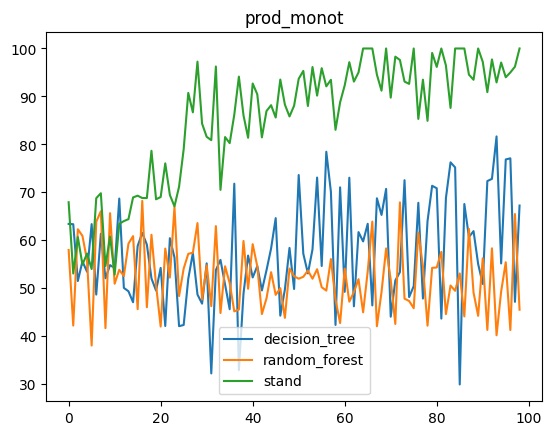

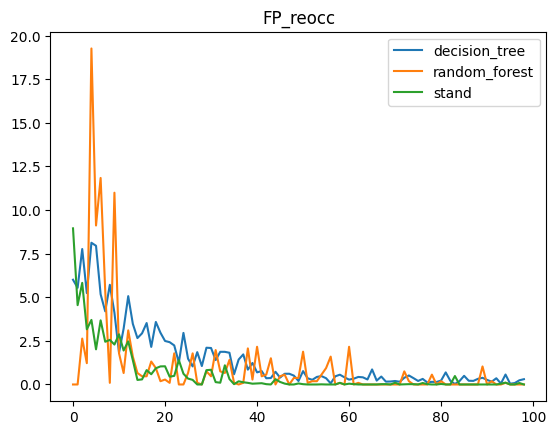

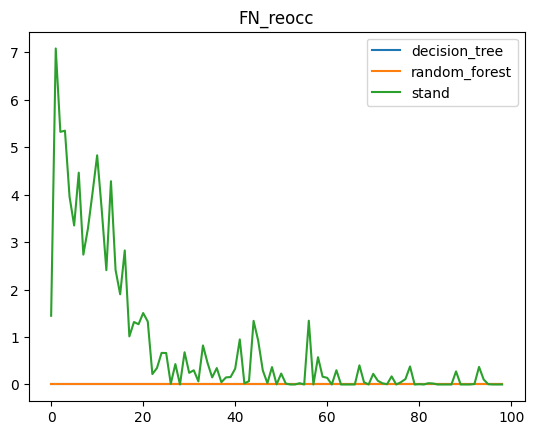

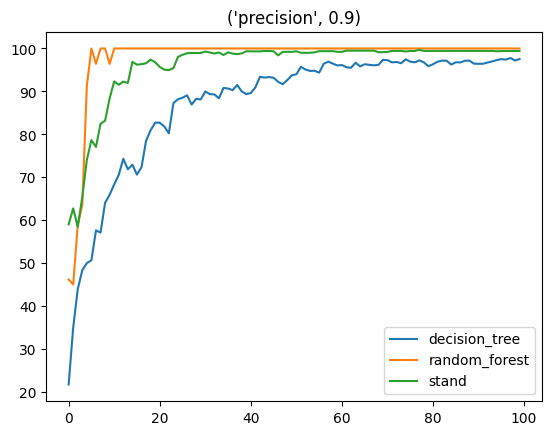

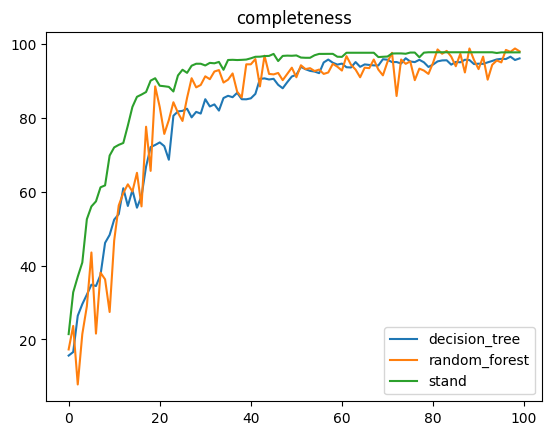

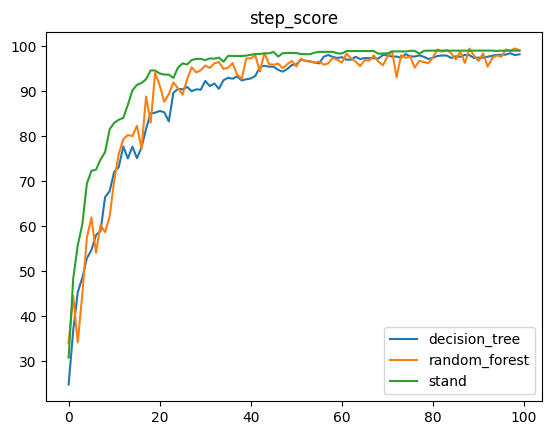

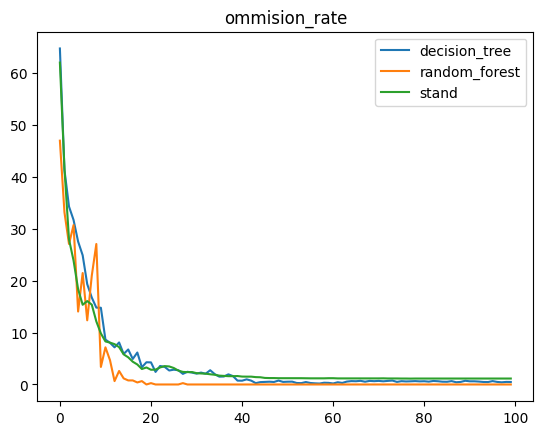

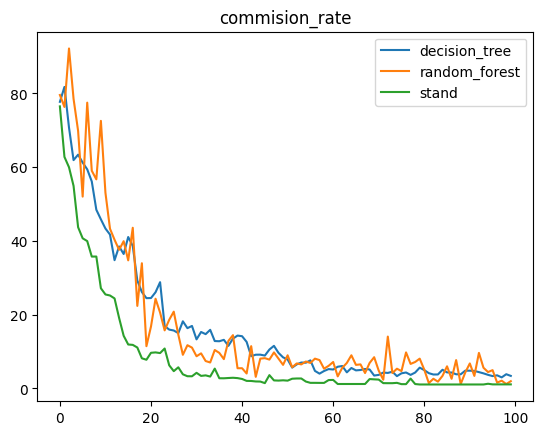

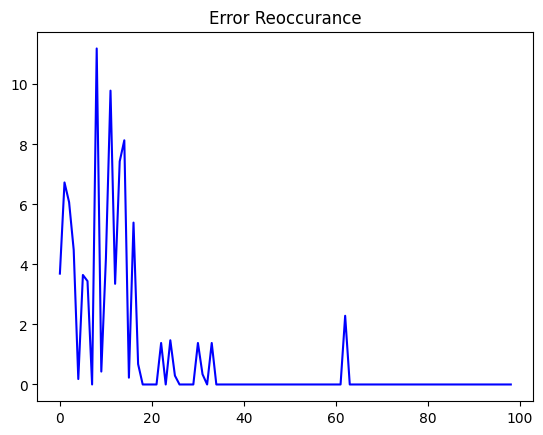

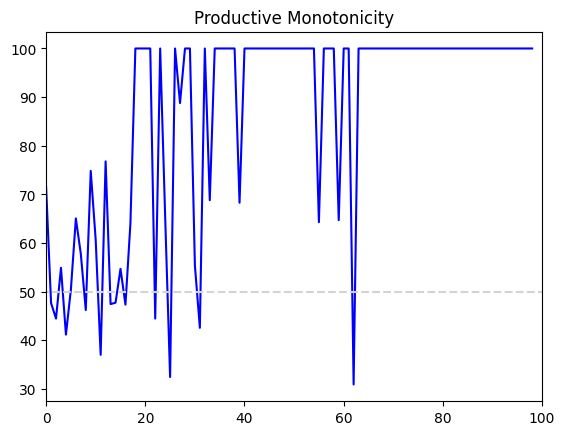

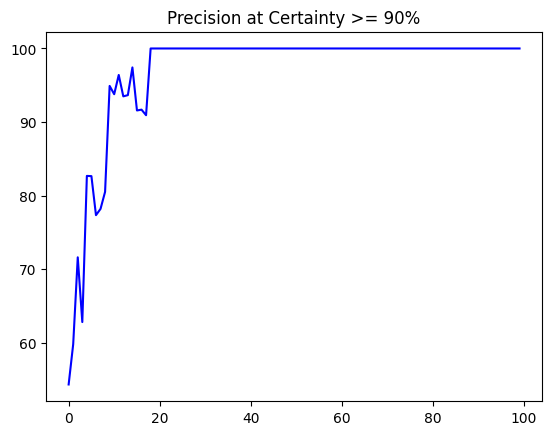

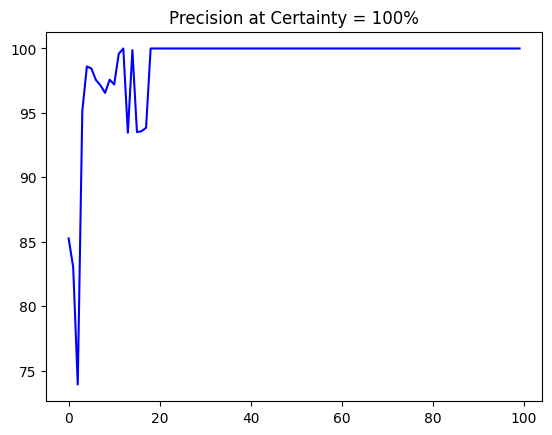

In [86]:
import matplotlib.pyplot as plt
import numpy as np


def plot_stat(conditions, stat, grp=1, title=None):
    title = title if title else stat
    for cond, curve in stats_by_cond(conditions, grp, stat).items():
        when, has_proc = cond 
        plt.plot(curve*100,#, color='blue', 
                 label=when+("(proc. lrn.)" if has_proc else ""))
    plt.title(title)
    plt.legend()    
    plt.show()
    
plot_stat(mc_conditions, "prod_monot")
plot_stat(mc_conditions, "FP_reocc")
plot_stat(mc_conditions, "FN_reocc")
plot_stat(mc_conditions, ('precision', .9))
plot_stat(mc_conditions, "completeness", 0)
plot_stat(mc_conditions, "step_score", 0)
plot_stat(mc_conditions, "ommision_rate", 0)
plot_stat(mc_conditions, "commision_rate", 0)


plt.plot(wp_stats["error_reocc"]['avg']*100, color='blue')
plt.title("Error Reoccurance")
plt.show()

plt.plot(wp_stats["prod_monot"]['avg']*100, color='blue')
plt.title("Productive Monotonicity")
plt.hlines(50, -1, 100, linestyle='--', color="lightgray")
plt.xlim(0, 100)
plt.show()

plt.plot(wp_stats[('precision', .9)]['avg']*100, color='blue')
plt.title("Precision at Certainty >= 90%")
plt.show()

plt.plot(wp_stats[('precision', 1.0)]['avg']*100, color='blue')
plt.title("Precision at Certainty = 100%")
plt.show()